# Conrady Dispersion Fit – 3 Lines vs. Full Visible Spectrum

This notebook compares the accuracy of a **three‑line Conrady fit**  
using only the classical Fraunhofer F–d–C lines (486.13 nm, 587.56 nm, 656.27 nm)  
with a **multi‑line fit** that uses every refractive‑index measurement provided
for 400–700 nm in the SCHOTT glass catalogue.

For each of 10 frequently used glasses we

1. load the refractive‑index data from the Excel sheet `schott-optical-glass.xlsx`;
2. solve for the Conrady coefficients  

$$\;n(\lambda)=A+\frac{B}{\lambda}+\frac{C}{\lambda^{3.5}}$$
   with
   * only F,d,C lines and  
   * all available \(400\,\text{nm} \le \lambda \le 700\,\text{nm}\);
3. compute the root‑mean‑square (RMS) and maximum absolute error of the two fits  
   over the same visible range;  
4. collect the results in a summary table and show one detailed example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit, OptimizeWarning
import warnings

In [2]:
def get_project_root() -> Path:
    return Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent

root      = get_project_root()
xls_file  = root / "references" / "schott-optical-glass.xlsx"
df        = (pd.read_excel(xls_file, sheet_name="Preferred glasses", engine="openpyxl")
               .rename(columns=str.strip))
df["Glass"] = df["Glass"].str.strip()

# ── wavelength dictionary  |  *visible only* (400‑700 nm) ────────────────
wl_map = {
    # violet
    'nh'     : 404.657,
    'ng'     : 435.835,
    # blue
    "nF'"    : 479.990,
    'nF'     : 486.130,
    # green / yellow
    'ne'     : 546.070,
    'nd'     : 587.560,
    'nD'     : 589.290,
    # orange / red
    'n632.8' : 632.800,
    "nC'"    : 643.846,
    'nC'     : 656.272,
    'nr'     : 706.520,
    # near‑IR
    'ns'     : 852.113,
    'nt'     : 1013.98,
    'n1060.0': 1060.00
}


# ── column lists actually present in the catalogue ───────────────────────
wl_cols     = [c for c in wl_map if c in df.columns]
wl_cols_visible  = [col for col in wl_cols               # 400 ≤ λ ≤ 700 nm
                if 400 <= wl_map[col] <= 700]

print("Columns found: ", wl_cols_visible)

# ── glass selections ─────────────────────────────────────────────────────
all_glasses = df["Glass"].unique().tolist()

common_glasses = [
    "N-BK7", "N-BK10", "N-FK5",
    "N-BAK2", "N-BAK4", "N-LAK22", "N-LAK33B",
    "N-KZFS4", "N-KZFS5",
    "N-SF10", "N-SF11", "N-SF6",
    "N-LASF9", "N-BAF10", "N-LAF21",
    "F2", "N-F2", "SF11"
]

# keep only those that actually exist in the sheet
common_glasses = [g for g in common_glasses if g in all_glasses]

if len(common_glasses) < 10:
    print("Preferred list incomplete – falling back to first 10 catalogue entries.")
    common_glasses = all_glasses[:10]

print("common_glasses:", common_glasses)

Columns found:  ['nh', 'ng', "nF'", 'nF', 'ne', 'nd', 'nD', 'n632.8', "nC'", 'nC']
common_glasses: ['N-BK7', 'N-BK10', 'N-FK5', 'N-BAK2', 'N-BAK4', 'N-LAK22', 'N-LAK33B', 'N-KZFS4', 'N-KZFS5', 'N-SF10', 'N-SF11', 'N-SF6', 'N-LASF9', 'N-BAF10', 'N-LAF21', 'F2', 'N-F2', 'SF11']


In [3]:
def conrady(lam_nm, A, B, C):
    lam_nm = np.asarray(lam_nm, float)
    return A + B/lam_nm + C/lam_nm**3.5

def fit_conrady(lam_nm, n, initial=(1.5, 1e3, 1e8)):
    lam_nm, n = map(np.asarray, (lam_nm, n))
    if len(lam_nm) == 3:                      # analytical 3‑point solution
        M = np.column_stack([np.ones_like(lam_nm), 1/lam_nm, 1/lam_nm**3.5])
        return np.linalg.solve(M, n)          # A, B, C
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(conrady, lam_nm, n, p0=initial, maxfev=10000)
    return popt                               # A, B, C

def rmse(y, yhat): return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))

def acf(lam_nm, a, b, c, d, x1, x2, x3):
    lam_nm = np.asarray(lam_nm, float)
    return 1 + a + b / lam_nm**x1 + c / lam_nm**x2 + d * lam_nm**x3

def fit_acf(lam_nm, n,
            initial=(0.0, 1e7, 1e12, 1e-12, 2.8, 5.8, 0.3),
            bounds=((-np.inf,     0,     0, -np.inf,   0.1, 1.0, -5.0),
                    ( np.inf, 1e10, 1e15,  np.inf,   6.0,10.0,  5.0))):
    """Least‑squares fit of all 7 ACF parameters."""
    lam_nm, n = map(np.asarray, (lam_nm, n))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(acf, lam_nm, n, p0=initial,
                            bounds=bounds, maxfev=40000)
    return popt   # a, b, c, d, x1, x2, x3

In [4]:
# ── 1 · Define columns & wavelengths used for each purpose ───────────────
fit_cols   = ["nF", "nd", "nC"]                    # three classic lines
fit_lambda = [wl_map[c] for c in fit_cols]         # → [486.13, 587.56, 656.272]

eval_cols  = wl_cols_visible                           # all visible‑band columns
eval_lambda = [wl_map[c] for c in eval_cols]

print("   λ used for 3‑param fit:", [wl_map[c] for c in fit_cols])
print("   λ used for RMS eval  :", [wl_map[c] for c in eval_cols])

# ── 2 · Run the fits & build the table ───────────────────────────────────
results_conrady = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    lam_all = np.array(eval_lambda, float)
    n_all   = np.array([row[c] for c in eval_cols], float)

    # --- 3‑line fit -------------------------------------------------------
    n_fdc = row[fit_cols].to_numpy(float)
    A3, B3, C3 = fit_conrady(fit_lambda, n_fdc)

    # --- full least‑squares fit ------------------------------------------
    Af, Bf, Cf = fit_conrady(lam_all, n_all)

    n_pred_3   = conrady(lam_all, A3, B3, C3)
    n_pred_all = conrady(lam_all, Af, Bf, Cf)

    results_conrady.append(dict(
        Glass=glass,
        num_lines=len(lam_all),
        pts_3_RMS = rmse(n_all, n_pred_3),
        pts_3_max = np.max(np.abs(n_all - n_pred_3)),
        full_RMS  = rmse(n_all, n_pred_all),
        full_max  = np.max(np.abs(n_all - n_pred_all)),
        A=A3, B=B3, C=C3
    ))

# --- 3 · Display with 1‑based counter ------------------------------------
summary = pd.DataFrame(results_conrady).sort_values("Glass").reset_index(drop=True)
summary.insert(0, "#", summary.index + 1)

styled = (summary[["#", "Glass", "A", "B", "C",
                   "num_lines", "pts_3_RMS", "pts_3_max",
                   "full_RMS", "full_max"]]
          .style.format({
              "A":"{:+.3e}", "B":"{:+.3e}", "C":"{:+.3e}",
              "pts_3_RMS":"{:.1e}", "pts_3_max":"{:.1e}",
              "full_RMS":"{:.1e}", "full_max":"{:.1e}"
          }))

display(styled)


   λ used for 3‑param fit: [486.13, 587.56, 656.272]
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272]


,#,Glass,A,B,C,num_lines,pts_3_RMS,pts_3_max,full_RMS,full_max
0,1,F2,+1.586e+00,+1.583e+01,+3.353e+07,10,2.7e-05,8.5e-05,7.0e-06,1.5e-05
1,2,N-BAF10,+1.640e+00,+1.488e+01,+2.447e+07,10,2.1e-05,6.3e-05,4.4e-06,7.8e-06
2,3,N-BAK2,+1.519e+00,+1.059e+01,+1.321e+07,10,2.7e-05,8.2e-05,6.1e-06,1.0e-05
3,4,N-BAK4,+1.546e+00,+1.166e+01,+1.537e+07,10,1.9e-05,5.9e-05,5.5e-06,1.2e-05
4,5,N-BK10,+1.480e+00,+9.582e+00,+9.077e+06,10,5.2e-06,1.5e-05,2.3e-06,3.8e-06
5,6,N-BK7,+1.497e+00,+1.011e+01,+1.040e+07,10,8.5e-06,2.3e-05,2.5e-06,5.9e-06
6,7,N-F2,+1.587e+00,+1.554e+01,+3.402e+07,10,8.6e-05,2.6e-04,2.0e-05,3.8e-05
7,8,N-FK5,+1.471e+00,+8.930e+00,+8.406e+06,10,5.8e-06,1.6e-05,2.6e-06,5.8e-06
8,9,N-KZFS4,+1.583e+00,+1.493e+01,+2.267e+07,10,3.7e-06,9.7e-06,1.9e-06,4.1e-06
9,10,N-KZFS5,+1.620e+00,+1.665e+01,+2.961e+07,10,2.0e-05,6.0e-05,4.9e-06,8.4e-06


In [5]:
# ── 7 fixed wavelengths covering 404‑1060 nm ─────────────────────────────
fit_cols   = ["nh", "ng", "nF", "ne", "nC", "ns", "n1060.0"]
fit_lambda = [wl_map[c] for c in fit_cols]

# columns available in catalogue for 400‑1100 nm evaluation
wl_cols_eval = [c for c in wl_map if c in df.columns and 400 <= wl_map[c] <= 1100]

print("   λ used for 7‑param fit:", dict(zip(fit_cols, fit_lambda)))
print("   λ used for RMS eval  :", [wl_map[c] for c in wl_cols_eval])

# ── perform the ACF fits --------------------------------------------------
results_acf = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    # --- 7‑point fit set --------------------------------------------------
    if row[fit_cols].isna().any():
        missing = list(row[fit_cols][row[fit_cols].isna()].index)
        print(f"Skipping {glass}: missing {missing} data.")
        continue

    lam_fit = np.array(fit_lambda, float)
    n_fit   = row[fit_cols].to_numpy(float)

    # --- evaluation set (all 400‑1100 nm lines present) ------------------
    lam_eval = np.array([wl_map[c] for c in wl_cols_eval if not np.isnan(row[c])], float)
    n_eval   = np.array([row[c]    for c in wl_cols_eval if not np.isnan(row[c])], float)

    # fit 7 parameters
    a, b, c, d, x1, x2, x3 = fit_acf(lam_fit, n_fit)
    n_pred = acf(lam_eval, a, b, c, d, x1, x2, x3)

    results_acf.append(dict(
        Glass=glass,
        a=a, b=b, c=c, d=d, x1=x1, x2=x2, x3=x3,
        num_lines=len(lam_eval),
        ACF_RMS = rmse(n_eval, n_pred),
        ACF_max = np.max(np.abs(n_eval - n_pred))
    ))

# ── table with 1‑based counter ------------------------------------------
summary_acf = pd.DataFrame(results_acf).sort_values("Glass").reset_index(drop=True)
summary_acf.insert(0, "#", summary_acf.index + 1)

styled = (summary_acf[["#", "Glass", "a", "b", "c", "d",
                       "x1", "x2", "x3",
                       "num_lines", "ACF_RMS", "ACF_max"]]
          .style.format({
              "a":"{:+.3e}", "b":"{:+.3e}", "c":"{:+.3e}", "d":"{:+.3e}",
              "x1":"{:.3f}", "x2":"{:.3f}", "x3":"{:.3f}",
              "ACF_RMS":"{:.2e}", "ACF_max":"{:.2e}"
          }))

display(styled)

   λ used for 7‑param fit: {'nh': 404.657, 'ng': 435.835, 'nF': 486.13, 'ne': 546.07, 'nC': 656.272, 'ns': 852.113, 'n1060.0': 1060.0}
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272, 706.52, 852.113, 1013.98, 1060.0]


,#,Glass,a,b,c,d,x1,x2,x3,num_lines,ACF_RMS,ACF_max
0,1,F2,+6.391e-01,+1.153e+06,+4.895e+09,-4.820e-03,2.856,5.902,0.303,14,1.97e-05,3.76e-05
1,2,N-BAF10,+6.954e-01,+9.931e+05,+4.633e+09,-5.186e-03,2.875,6.104,0.305,14,4.09e-05,7.55e-05
2,3,N-BAK2,+5.627e-01,+6.585e+05,+4.603e+09,-4.228e-03,2.896,6.142,0.302,14,4.72e-05,7.81e-05
3,4,N-BAK4,+5.927e-01,+7.297e+05,+4.614e+09,-4.524e-03,2.890,6.129,0.302,14,4.50e-05,7.65e-05
4,5,N-BK10,+5.227e-01,+5.404e+05,+4.230e+09,-4.336e-03,2.912,6.447,0.301,14,3.02e-05,4.78e-05
5,6,N-BK7,+5.413e-01,+5.856e+05,+4.625e+09,-4.318e-03,2.906,6.122,0.303,14,3.17e-05,6.09e-05
6,7,N-F2,+6.393e-01,+1.159e+06,+5.457e+09,-4.695e-03,2.857,5.453,0.308,14,6.38e-05,1.17e-04
7,8,N-FK5,+5.110e-01,+5.134e+05,+4.377e+09,-4.062e-03,2.916,6.360,0.302,14,2.56e-05,3.75e-05
8,9,N-KZFS4,+6.419e-01,+9.277e+05,+4.724e+09,-5.623e-03,2.873,6.040,0.303,14,2.26e-05,3.68e-05
9,10,N-KZFS5,+6.803e-01,+1.104e+06,+4.809e+09,-5.608e-03,2.863,5.968,0.305,14,9.79e-06,1.65e-05


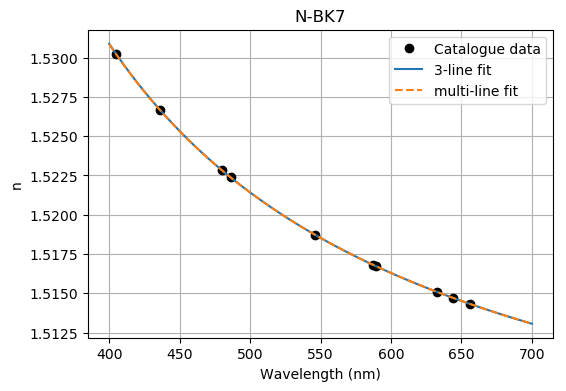

In [6]:
ex = 'N-BK7' if 'N-BK7' in common_glasses else common_glasses[0]
row = df[df['Glass']==ex].iloc[0]
lam_list, n_list = [], []
for col in wl_cols_visible:
    if not np.isnan(row[col]):
        lam_list.append(wl_map[col])
        n_list.append(row[col])
lam_arr = np.array(lam_list)
n_arr = np.array(n_list)
mask_fdc = np.isin(lam_arr, [486.13,587.56,656.272])
A3,B3,C3 = fit_conrady(lam_arr[mask_fdc], n_arr[mask_fdc])
Aall,Ball,Call = fit_conrady(lam_arr, n_arr)

plt.figure(figsize=(6,4))
plt.plot(lam_arr, n_arr, 'ko', label='Catalogue data')
lam_plot = np.linspace(400,700,301)
plt.plot(lam_plot, conrady(lam_plot, A3,B3,C3),  label='3‑line fit')
plt.plot(lam_plot, conrady(lam_plot, Aall,Ball,Call), '--', label='multi‑line fit')
plt.xlabel('Wavelength (nm)')
plt.ylabel('n')
plt.title(ex)
plt.legend()
plt.grid()
plt.show()